In [1]:
# import dependencies
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pmdarima import auto_arima 
import statsmodels.api as sm
import plotly.express as px
import plotly as py
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#filepath
NYT_file="Potential Data Sources/NYT- Cty Cases Deaths Thru Oct2/us-counties.csv"

#read dataset
NYT=pd.read_csv(NYT_file, parse_dates=['date'])

# limit dataset to texas
Texas=NYT.loc[NYT['state']=='Texas'].dropna(how='any', axis=0)
Texas2=Texas.drop(['state'], axis=1)

# Case Data Loop through Counties

In [3]:
# convert fips to integer
Texas2['fips'] = Texas2['fips'].astype(int)

In [4]:
# drop counties that have 0 cases before 7/31
Texas2 = Texas2[(Texas2.fips != 48033) & (Texas2.fips != 48431)]

In [5]:
# Form unique list of fips
TX_fips=Texas2['fips'].unique().tolist()
len(TX_fips)

250

In [6]:
# Form unique list of counties
TX_counties=Texas2['county'].unique().tolist()
len(TX_counties)

250

In [7]:
# run cases_best_training_model on EVERY county in the Texas Dataframe to get a dictionary of models

case_results = []
case_forecasts = []
sarimax_case_rmse = []
case_models={}
case_splits={}
case_full_models={}

# loop through counties
i = 0 
while i < len(TX_counties):
    county=str(TX_counties[i])
    fips=TX_fips[i]
    print(county)
    print(fips)

    # limit dataset to certain County
    countyData = Texas2.loc[(Texas2['county']==county)].reset_index(drop=True)
    County_Cases=countyData.drop(['deaths', 'county', 'fips'], axis=1)
    County_Cases=County_Cases.set_index('date')
    County_Cases=County_Cases.fillna(0)
  
    print(f' Currently processing {county}, number {i+1} of {len(TX_counties)} counties')

    #  test train split
    end_train=pd.to_datetime('2020-07-31')
    start_test=pd.to_datetime('2020-08-01')
    train=County_Cases[:end_train]
    test=County_Cases[start_test:]
    case_splits.update({'county':TX_counties[i]})
    case_splits.update({'train':train})
    case_splits.update({'test':test})
#     print(splits['test'].index)
    
    #   call fxn to determine model best params & run model with them
    #   cases_best_training_model(countyData)
    stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 10, max_q = 30, m = 2,
                          start_P = 0, seasonal = True, 
                          stationary=True,
                          trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
    # pull out the parameters of the best model for this county
    x=stepwise_fit.get_params()
    
    # override Q parameter if 0 to 1
    so=x['seasonal_order']
    so_slice1=so[ :2]
    so_slice2=so[3:]
    if so[2]==0 & so[3]!= 0:
        so=so_slice1+ (1,) +so_slice2
    
    # runs model with best fit ARIMA params
    model = SARIMAX(train,
                    order = (x['order']),
                    seasonal_order =(so),
                    initialization='approximate_diffuse')

    result = model.fit()
    case_models.update({county: result})
    
    start = len(train) 
    end = len(train) + len(test) - 1

    # Predictions for the test set 
    predictions = result.predict(start, end)
    predicted_df = pd.DataFrame(data=predictions, columns=["sarimax_cases_predicted"])
    predicted_df['sarimax_cases_expected'] = test
    modeled_df = predicted_df.drop(columns='sarimax_cases_expected')
    
    # Calculate rmse and store
    rmse = sqrt(mean_squared_error(predicted_df['sarimax_cases_expected'], predicted_df['sarimax_cases_predicted']))
    sarimax_case_rmse.append(rmse)
    
    # Calculate residuals
    residuals = predicted_df['sarimax_cases_expected'] - predicted_df['sarimax_cases_predicted']
    residuals_df = pd.DataFrame(data=residuals, columns=["sarimax_cases_residuals"])
    
    # Put everything together in dataframe  
    results_df = modeled_df.join(residuals_df)
    results_df['fips_code'] = fips
    case_results.append(results_df)
    
    #  get results for full dataset:
    end_full=pd.to_datetime('2020-10-03')
    start_full=pd.to_datetime('2020-04-01')
    formodel=County_Cases[start_full:end_full]

    #   cases_best_training_model for full data
    stepwise_fit_full = auto_arima(formodel, start_p = 1, start_q = 1, 
                                   max_p = 10, max_q = 30, m = 2,
                                   start_P = 0, seasonal = True, 
                                   stationary=True,
                                   trace = True, 
                                   error_action ='ignore',   # we don't want to know if an order does not work 
                                   suppress_warnings = True,  # we don't want convergence warnings 
                                   stepwise = True)           # set to stepwise 
    
    # pull out the parameters of the best model for this county
    x_full=stepwise_fit_full.get_params()
    
    # override Q parameter if 0 to 1
    so_full=x_full['seasonal_order']
    so_full_slice1=so_full[ :2]
    so_full_slice2=so_full[3:]
    if so_full[2]==0 & so_full[3]!= 0:
        so_full=so_full_slice1+ (1,) +so_full_slice2
    
    # runs model with best fit ARIMA params
    full_model = SARIMAX(formodel,
                    order = (x_full['order']),
                    seasonal_order =(so_full),
                    initialization='approximate_diffuse')

    full_result = full_model.fit()
    case_full_models.update({county: full_result})
    
    # Getting 90 days for forecasts and store
    SARIMAX_forecast = round(full_result.forecast(steps = 90))
    idx = pd.date_range('2020-10-04', '2021-01-01', freq='d')
    SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
    columns=['date','sarimax_cases_forecasted'])
    SARIMAX_forecast['fips_code'] = fips
    case_forecasts.append(SARIMAX_forecast)
    
    i = i + 1
    print("Done")

Bexar
48029
 Currently processing Bexar, number 1 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2639.649, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3649.116, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3700.478, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2659.876, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2597.810, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2635.354, Time=0.24 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2599.665, Time=0.36 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2641.741, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2627.465, Time=0.31 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=2599.908, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, T

 ARIMA(1,0,1)(0,0,2)[2]             : AIC=2322.159, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=2314.099, Time=0.16 sec
 ARIMA(0,0,1)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 9.008 seconds
Done
Harris
48201
 Currently processing Harris, number 3 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2217.319, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3373.878, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3458.057, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2308.546, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2137.321, Time=0.30 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2152.432, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept  

 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=2395.396, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2392.420, Time=0.38 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2405.227, Time=0.30 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2398.582, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=2389.080, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=2424.243, Time=0.19 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=2391.821, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=2393.650, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=2411.432, Time=0.24 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AI

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2205.796, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3594.092, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3739.694, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2236.462, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2207.650, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2208.949, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=2250.718, Time=0.18 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=2204.552, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=2235.196, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 s

 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1904.510, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1890.194, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1905.698, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1891.398, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1891.433, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1903.254, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=2071.344, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1890.977, Time=0.24 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf

 ARIMA(0,0,1)(2,0,0)[2]             : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 5.578 seconds
Done
Galveston
48167
 Currently processing Galveston, number 11 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1667.120, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2615.952, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2681.998, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1695.933, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1615.977, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1647.431, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1612.639, Time=0.37 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept

 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=2018.188, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1978.258, Time=0.24 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=2191.099, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1977.119, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.505 seconds
Done
Travis
48453
 Currently processing Travis, number 13 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1824.555, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2866.317, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2944.746, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : A

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1374.526, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1393.746, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1374.748, Time=0.34 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1373.457, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1419.773, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1391.828, Time=0.28 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1372.371, Time=0.22 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1418.509, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1373.455, Time=0.17 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1377.295, Time=0.27 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1434.628, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1373.656, Time=0.23 sec
 ARIMA(0,0,1)(1,0,2)[2]  

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1032.442, Time=0.24 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1025.349, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1020.839, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1038.757, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1022.236, Time=0.27 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1022.236, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1037.927, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1023.952, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1019.645, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1037.489, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[2]            

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1213.628, Time=0.23 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1241.368, Time=0.18 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1204.626, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1283.090, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1216.988, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1206.321, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1206.127, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1349.776, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1256.673, Time=0.13 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1212.540, Time=0.16 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1208.172, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[2]       

 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1375.638, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1431.671, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1396.666, Time=0.11 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1400.465, Time=0.18 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1377.393, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1487.194, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1419.956, Time=0.12 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1391.801, Time=0.15 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1377.765, Time=0.26 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1396.954, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1656.892, Time=0.08 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 4.979 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercep

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1946.844, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3500.639, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3618.615, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2005.557, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1916.469, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1915.888, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1916.657, Time=0.32 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1914.707, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=2004.275, Time=0.07 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1915.503, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[2]            

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1601.775, Time=0.19 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1569.236, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1570.457, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1570.917, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1570.661, Time=0.05 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1570.949, Time=0.10 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1600.537, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1801.830

 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1451.758, Time=0.23 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1497.279, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1521.179, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1491.212, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1481.654, Time=0.17 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1460.087, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1746.747, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 5.987 seconds
Done
Williamson
48491
 Currently processing Williamson, number 28 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] interce

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=2598.075, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2594.926, Time=0.38 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=2593.137, Time=0.34 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=2592.943, Time=0.27 sec

Best model:  ARIMA(1,0,1)(2,0,1)[2] intercept
Total fit time: 4.781 seconds
Done
Crane
48103
 Currently processing Crane, number 30 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=542.177, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1265.216, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=943.876, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1353.059, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=551.870, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept 

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1270.953, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1248.623, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1279.361, Time=0.19 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1252.743, Time=0.21 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1247.378, Time=0.19 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1278.099, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1248.491, Time=0.15 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1278.642, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1248.062, Time=0.21 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1251.510, Time=0.19 sec
 ARIMA(0,0,0)(1,0,2)[2]            

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=975.485, Time=0.17 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=975.468, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=984.072, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=974.532, Time=0.16 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1100.152, Time=0.05 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=975.478, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 5.174 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1509.137, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2633.418, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2756.374, 

 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(1,0,0)(1,0,2)[2]          
Total fit time: 5.599 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1536.698, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2570.887, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2679.107, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1539.272, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1527.564, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1536.031, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1529.524, Time=0.36 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1537.647, Time=0.28 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1575.507, Time=0.17 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=

 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 5.527 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=992.751, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2368.246, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2494.582, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1010.261, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=952.324, Time=0.34 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=953.961, Time=0.36 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=989.920, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=982.255, Time=0.28 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=952.835, T

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=610.113, Time=0.25 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=761.368, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=607.305, Time=0.13 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=636.852, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=609.557, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=640.170, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=608.844, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=760.727, Time=0.07 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=607.659, Time=0.17 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.38 sec

Best model:  ARIMA(1,0,0)(1,0,2)[2]          
Total fit time: 5.503 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=898.464, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2212.167, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=

 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1254.104, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1422.020, Time=0.06 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 4.785 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1948.445, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3228.811, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=3354.544, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1949.223, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1914.201, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1912.166, 

 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=2239.070, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=2235.411, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=2407.072, Time=0.08 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 4.670 seconds
Done
Morris
48343
 Currently processing Morris, number 45 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=493.299, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1200.448, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1301.095, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=495.988, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=476.031, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   :

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1529.902, Time=0.38 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1554.823, Time=0.28 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1552.486, Time=0.34 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1527.863, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1525.851, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1556.588, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1527.636, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1527.450, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1557.068, Time=0.23 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1526.073, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1524.716, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]       

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1071.535, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1039.398, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1063.147, Time=0.22 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1040.694, Time=0.39 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1040.465, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1063.578, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1058.707, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1037.499, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1068.473, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1038.815, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1038.668, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1064.627, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[2] i

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=2584.129, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=4025.134, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=4139.206, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2607.108, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2541.700, Time=0.36 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2559.847, Time=0.35 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2574.174, Time=0.36 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2549.016, Time=0.30 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=2526.102, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AI

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=2342.751, Time=0.36 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2389.882, Time=0.26 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=2371.498, Time=0.41 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=2350.225, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=2405.833, Time=0.31 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2375.630, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=2340.456, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=2443.266, Time=0.20 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=2344.058, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=2425.857, Time=0.26 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept  

 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1951.755, Time=0.32 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1997.939, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1954.277, Time=0.22 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=2004.669, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1958.555, Time=0.37 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=2739.884, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1950.647, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1996.675, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1953.156, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1953.899, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=2003.399, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1952.329, Time=0.17 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=2163.210, Time=0.15 sec
 ARIMA(1,0,1)(1,0,2)

 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1079.531, Time=0.16 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1060.504, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1066.424, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1302.958, Time=0.09 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 5.830 seconds
Done
Blanco
48031
 Currently processing Blanco, number 57 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=594.680, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1207.807, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=914.208, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1272.190, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=592.722, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1392.354, Time=0.20 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1392.353, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1408.678, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1394.201, Time=0.24 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1578.267, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1392.155, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.815 seconds
Done
Coryell
48099
 Currently processing Coryell, number 59 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=952.065, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1670.563, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept

 ARIMA(1,0,0)(2,0,2)[2]             : AIC=919.514, Time=0.22 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=927.740, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=927.811, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=925.872, Time=0.12 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1092.981, Time=0.14 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=921.496, Time=0.37 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,0)(2,0,2)[2]          
Total fit time: 7.597 seconds
Done
Erath
48143
 Currently processing Erath, number 61 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=862.325, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1594.500, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1641.817, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : 

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=556.260, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=566.394, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=565.900, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=557.903, Time=0.28 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=568.447, Time=0.15 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=565.990, Time=0.17 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=553.354, Time=0.31 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=565.053, Time=0.24 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=552.188, Time=0.21 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=556.753, Time=0.18 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=555.100, Time=0.14 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC

 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1154.337, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1193.796, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1156.026, Time=0.15 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1156.043, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1186.483, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1322.305, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1156.033, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Tot

 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1047.321, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1045.198, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1069.444, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=1403.943, Time=0.31 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1043.919, Time=0.15 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1068.186, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1045.141, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1046.015, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1071.314, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1044.200, Time=0.13 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1198.352, Time=0.09 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1045.875, Time=0.20 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(1,0,0

 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1025.140, Time=0.20 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1078.329, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1039.594, Time=0.14 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1026.759, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1082.227, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1032.320, Time=0.18 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1038.407, Time=0.13 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1191.256, Time=0.09 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 4.594 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1561.989, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2915.622, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   :

 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=634.564, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=607.536, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=739.267, Time=0.08 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=608.335, Time=0.25 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.46 sec

Best model:  ARIMA(1,0,0)(1,0,2)[2]          
Total fit time: 5.829 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1392.222, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2221.493, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2370.107, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1390.275, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1391.905,

 ARIMA(0,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1701.977, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1739.331, Time=0.12 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1703.265, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1718.864, Time=0.17 sec
 ARIMA(0,0,1)(2,0,0)[2]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 4.160 seconds
Done
Limestone
48293
 Currently processing Limestone, number 74 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=707.148, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1348.279, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : A

 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1936.608, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1984.092, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1341.272, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1322.922, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1340.246, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1344.030, Time=0.31 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1306.573, Time=0.28 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1340.450, Time=0.24 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1326.587, Time=0.33 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1304.575, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1343.387, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1321.549, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2] i

 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1862.937, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1207.434, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1200.171, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1206.580, Time=0.20 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1201.411, Time=0.30 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1207.201, Time=0.23 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1206.246, Time=0.28 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1202.071, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1198.476, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1209.584, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1199.579, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2] interc

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1036.143, Time=0.30 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1040.533, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1044.687, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1042.722, Time=0.18 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1042.331, Time=0.20 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1045.084, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1034.926, Time=0.17 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1042.806, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1039.309, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1035.477, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[2]            

 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1256.901, Time=0.30 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1250.072, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1250.872, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1252.203, Time=0.18 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1253.729, Time=0.12 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1255.762, Time=0.28 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1366.942, Time=0.21 sec

Best model:  ARIMA(1,0,1)(2,0,2)[2]          
Total fit time: 4.630 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1808.975, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3239.036, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1401.430, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1409.953, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1398.265, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1419.706, Time=0.35 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1400.248, Time=0.46 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1416.492, Time=0.30 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1397.110, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1418.448, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1400.300, Time=0.19 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1399.094, Time=0.42 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1422.745, Time=0.10 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(1,0,2)[2]       

 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1782.727, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1780.957, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1808.131, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1778.500, Time=0.24 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1971.634, Time=0.46 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1780.313, Time=0.33 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,0)(2,0,2)[2]          
Total fit time: 8.188 seconds
Done
Calhoun
48057
 Currently processing Calhoun, number 87 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=899.618, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1557.936, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept 

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1378.396, Time=0.45 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1377.919, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1380.920, Time=0.36 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1380.932, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1378.944, Time=0.24 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1376.836, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1379.841, Time=0.24 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1379.853, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1377.867, Time=0.11 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1559.757, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1377.339, Time=0.40 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,0)(2,0,

 ARIMA(1,0,0)(0,0,1)[2]             : AIC=550.857, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=519.805, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=519.845, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=541.078, Time=0.19 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=520.202, Time=0.32 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=729.649, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=518.564, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 8.302 seconds
Done
Nacogdoches
48347
 Currently processing Nacogdoches, number 91 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1005.560, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] interce

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1588.302, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1593.622, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1588.514, Time=0.19 sec
 ARIMA(0,0,0)(2,0,1)[2]             : AIC=1815.385, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1590.287, Time=0.25 sec
 ARIMA(0,0,1)(2,0,1)[2]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(1,0,0)(2,0,1)[2]          
Total fit time: 6.719 seconds
Done
Val Verde
48465
 Currently processing Val Verde, number 93 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1254.745, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1891.547, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1580.901, Time=0.19 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1567.318, Time=0.22 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1567.325, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1619.649, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1579.823, Time=0.10 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1755.446, Time=0.19 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1567.887, Time=0.35 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(1,0,0)(2,0,2)[2]          
Total fit time: 5.768 seconds
Done
Harrison
48203
 Currently processing Harrison, number 95 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=844.618, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1664.289, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] int

 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1346.782, Time=0.22 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1340.451, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1347.517, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1347.529, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1345.578, Time=0.11 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=1576.730, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1341.021, Time=0.30 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=1.33 sec

Best model:  ARIMA(1,0,0)(2,0,2)[2]          
Total fit time: 7.303 seconds
Done
Montague
48337
 Currently processing Montague, number 97 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=379.045, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1004.011, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[2] int

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1081.895, Time=0.16 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1071.253, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1087.961, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=1081.718, Time=0.12 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1075.874, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1100.305, Time=0.05 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1084.191, Time=0.12 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1080.318, Time=0.13 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1080.634, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AI

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1255.841, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1272.678, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1257.393, Time=0.31 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1257.421, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1273.510, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1264.980, Time=0.24 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1258.650, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1253.841, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1286.293, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1255.404, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1255.432, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1277.192, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[2] i

 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1979.443, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1994.508, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1981.147, Time=0.24 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1981.129, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1994.426, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=2154.927, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1980.799, Time=0.22 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 8.099 seconds
Done
Uvalde
48463
 Currently processing Uvalde, number 103 of 250 counties
Performing stepwise 

 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1657.932, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1661.052, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1662.500, Time=0.13 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1661.576, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1849.103, Time=0.08 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 6.348 seconds
Done
Young
48503
 Currently processing Young, number 105 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=598.778, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1230.537, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC

 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1036.641, Time=0.30 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1034.353, Time=0.34 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1010.385, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1004.782, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1043.424, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1006.113, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1005.743, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1043.199, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1008.676, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1003.573, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1042.148, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[2]       

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=946.779, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=944.483, Time=0.41 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=981.220, Time=0.29 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=945.908, Time=0.53 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=944.742, Time=0.30 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=943.382, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=979.956, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=945.669, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=944.576, Time=0.40 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=979.766, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1179.183, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1155.786, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1181.265, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1154.175, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1186.884, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1152.901, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1154.524, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1153.079, Time=0.20 sec
 ARIMA(0,0,0)(2,0,1)[2]             : AIC=1276.288, Time=0.32 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AI

 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1983.670, Time=0.24 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=2142.405, Time=0.14 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 6.593 seconds
Done
Franklin
48159
 Currently processing Franklin, number 113 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=436.630, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1170.880, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=859.774, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1248.801, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=441.010, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=409.963, Time=0.37 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=440.588, Time=0.22 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=442.770, Time=0.39 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=404.476, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[

 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1323.063, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1389.591, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1316.011, Time=0.17 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1549.420, Time=0.10 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1316.312, Time=0.26 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(1,0,0)(1,0,2)[2]          
Total fit time: 6.928 seconds
Done
Kleberg
48273
 Currently processing Kleberg, number 115 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=777.337, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1499.105, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1541.351, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=803.391, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] inte

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=664.004, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=663.534, Time=0.15 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=665.046, Time=0.17 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=662.364, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=667.281, Time=0.05 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=663.890, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=662.909, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=663.296, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(1,0,0)[2]          
Total 

 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=743.107, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=693.682, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=693.297, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=730.449, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=694.648, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=691.565, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=741.845, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=692.407, Time=0.16 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=692.020, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=729.193, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf

 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1388.156, Time=0.22 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.993 seconds
Done
Leon
48289
 Currently processing Leon, number 121 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=679.010, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1284.682, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1334.926, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=688.402, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=677.570, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=676.662, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=678.049, Time=0.18 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=677.719, Time=0.29 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : 

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=740.586, Time=0.21 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=737.283, Time=0.13 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=771.879, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=740.646, Time=0.09 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=772.576, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=739.364, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=889.419, Time=0.08 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=739.003, Time=0.18 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,0)(1,0,2)[2]          
Total fit time: 4.937 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1320.753, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2620.844, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=964.724, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=964.622, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1000.151, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=961.384, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1002.220, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=963.338, Time=0.20 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=963.331, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=998.876, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2593.873, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1167.682, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1120.524, Time=0.36 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1138.445, Time=0.25 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1119.696, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1141.973, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1119.365, Time=0.42 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1119.610, Time=0.37 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1118.222, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1118.554, Time=0.29 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,1)(1,0,1)[2]            

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2861.250, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1646.220, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1640.193, Time=0.32 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1641.900, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1648.644, Time=0.27 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1638.574, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1647.446, Time=0.15 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1640.343, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1640.329, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AI

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1466.763, Time=0.31 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1468.962, Time=0.35 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1473.818, Time=0.26 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1470.762, Time=0.38 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1465.054, Time=0.21 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=1472.260, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1467.046, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1467.046, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=1473.263, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1469.054, Time=0.25 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept  

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1088.671, Time=0.19 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1088.728, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1090.905, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1249.518, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1088.037, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.833 seconds
Done
San Augustine
48405
 Currently processing San Augustine, number 134 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=582.491, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1305.386, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] i

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=1120.311, Time=0.30 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=1122.411, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1120.381, Time=0.29 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1119.132, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1119.273, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1121.132, Time=0.28 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1119.206, Time=0.17 sec
 ARIMA(0,0,0)(2,0,1)[2]             : AIC=1261.553, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=1120.878, Time=0.26 sec
 ARIMA(0,0,1)(2,0,1)[2]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(1,0,0)(2,0,1)[2]    

 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1304.011, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=1307.086, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=1305.803, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1305.792, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=1308.566, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1307.740, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1453.045, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1305.755, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.483 seconds
Done
Goliad
48175
 Currently processing Goliad, number 138 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=785.438, Time=0.15 sec
 ARIMA(0,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=784.277, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=796.299, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=786.259, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=785.843, Time=0.11 sec
 ARIMA(0,0,1)(2,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 2.770 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1643.779, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2849.001, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.20 s

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=659.052, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=658.592, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=659.481, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=657.428, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=666.955, Time=0.04 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=658.362, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=657.987, Time=0.17 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=660.617, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(1,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[2]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,1)(1,0,0)[2]          
Total 

 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=963.679, Time=0.23 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=956.370, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=950.289, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=944.722, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=972.258, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=945.501, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=945.591, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=966.873, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=948.611, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=943.578, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=970.987, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC

 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1110.664, Time=0.26 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1073.855, Time=0.29 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=1072.445, Time=0.23 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1109.379, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1081.432, Time=0.18 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=1085.125, Time=0.28 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1113.348, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=1072.601, Time=0.15 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1295.777, Time=0.10 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 5.857 seconds
Done
Hemphill
48211
 Currently processing Hemphill, number 147 of 250 counties
Perfor

 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=825.528, Time=0.19 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=779.764, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=830.095, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=780.341, Time=0.19 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=779.953, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=824.265, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=781.415, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1002.115, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=780.953, Time=0.25 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, T

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=657.571, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=654.888, Time=0.03 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=656.599, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=656.531, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.364 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1029.498, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2123.979, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.13 sec


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1327.739, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2265.087, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2436.786, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1326.947, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1327.393, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1314.276, Time=0.31 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1316.285, Time=0.35 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1316.242, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1327.248, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1326.216, Time=0.31 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1339.607, T

 ARIMA(1,0,0)(0,0,2)[2]             : AIC=309.758, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=303.163, Time=0.19 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=412.070, Time=0.05 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=302.500, Time=0.17 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 5.435 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=847.253, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1740.525, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1880.798, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=849.673, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=822.989, Time=0.34 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=850.517

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2296.624, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=921.862, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=893.538, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=894.056, Time=0.41 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=917.355, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=912.746, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=895.057, Time=0.38 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=891.787, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=926.393, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=892.270, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=892.155, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AI

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=800.847, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1850.027, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2007.457, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=805.263, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=790.375, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=798.440, Time=0.24 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=792.333, Time=0.40 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=792.957, Time=0.41 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=800.151, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=796.421, Time=0.29 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=794.191, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=788.561, Time=0

 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 5.746 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=608.880, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1786.886, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1898.389, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=615.316, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=586.777, Time=0.35 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=586.935, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=610.749, Time=0.22 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=608.498, Time=0.33 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0

 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1425.999, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=235.119, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=220.978, Time=0.39 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=229.315, Time=0.38 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=224.014, Time=0.48 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=226.234, Time=0.44 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=228.727, Time=0.30 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=228.879, Time=0.36 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=218.637, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=229.804, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=220.177, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AI

 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=856.459, Time=0.29 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=667.025, Time=0.21 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=677.651, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=676.636, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=668.985, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=680.908, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=678.067, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=671.454, Time=0.44 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=668.188, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=855.289, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 6.673 seconds
Done
Frio
48163
 Currently processing Frio, number 166 of 250 counties
Performing stepwise

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=748.056, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1083.514, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=462.153, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=448.908, Time=0.38 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=450.308, Time=0.33 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=458.494, Time=0.17 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=460.551, Time=0.17 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=452.869, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=455.658, Time=0.18 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=589.797, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=447.796, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=456.926, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1740.750, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2570.978, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2674.942, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1738.851, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1740.734, Time=0.20 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1742.530, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=2352.326, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1737.750, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=1739.659, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1740.070, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=2451.224, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[2]       

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=631.748, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=631.707, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=642.341, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=632.607, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=776.611, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=628.931, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=640.786, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=630.696, Time=0.24 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=630.671, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=641.120, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=631

 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=966.083, Time=0.22 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=966.095, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=968.695, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=967.744, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1095.066, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=966.391, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.683 seconds
Done
Cooke
48097
 Currently processing Cooke, number 175 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=674.285, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1219.904, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC

 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1645.621, Time=0.13 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 5.630 seconds
Done
Rains
48379
 Currently processing Rains, number 177 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=310.019, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=864.629, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=923.682, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=313.583, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=295.253, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=307.794, Time=0.17 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=296.618, Time=0.27 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=308.333, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=307.022, Time=0.17 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept 

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=379.208, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=387.059, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=386.218, Time=0.18 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=376.935, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=395.785, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=378.934, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=378.934, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=395.893, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=506.323, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=375.744, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=394

 ARIMA(1,0,0)(1,0,1)[2]             : AIC=-84.125, Time=0.15 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=-84.125, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-84.126, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,1)[2]          
Total fit time: 2.571 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-16.932, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=846.323, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1000.814, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-8.383, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-4.340, Time=0.37

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=312.376, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=311.918, Time=0.26 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=338.778, Time=0.13 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=311.608, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=346.151, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=325.450, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=311.879, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=356.244, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=317.380, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=438.328, Time=0.26 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=310.445, Time=0.12 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=344.945, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=324.275, Time=0.09 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=310.769, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[2]      

 Currently processing Freestone, number 186 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=545.642, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1106.280, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=845.830, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1157.612, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=563.008, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=543.432, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=544.512, Time=0.13 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=542.280, Time=0.26 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=547.080, Time=0.14 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=543.526, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=540.785, Time=0.17 s

 ARIMA(1,0,0)(0,0,2)[2]             : AIC=913.599, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=905.246, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=912.728, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=906.510, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=909.184, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1059.637, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=906.321, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.799 seconds
Done
Red River
48387
 Currently processing Red River, number 189 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=539.192, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept 

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=258.339, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=256.590, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=254.056, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=252.302, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=254.103, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=258.312, Time=0.12 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=250.605, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=260.005, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=252.253, Time=0.24 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=252.295, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=258.064, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC

 ARIMA(1,0,0)(2,0,2)[2]             : AIC=1142.016, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1294.029, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=1140.261, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.511 seconds
Done
Carson
48065
 Currently processing Carson, number 193 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=125.884, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=532.246, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=307.394, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=696.907, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=124.120, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=129.083, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept 

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=311.522, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=324.241, Time=0.13 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=311.754, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=308.928, Time=0.27 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=329.342, Time=0.14 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=328.828, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=308.557, Time=0.17 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=327.411, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=310.528, Time=0.15 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=325.421, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=310.994, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=402.275, Time=0.12 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=307.452, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[2]          

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=963.421, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=913.840, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=913.470, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=949.139, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=915.329, Time=0.29 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=911.923, Time=0.28 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=947.878, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=912.116, Time=0.20 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=951.395, Time=0.09 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Ti

 ARIMA(0,0,0)(1,0,2)[2]             : AIC=1094.549, Time=0.08 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 4.730 seconds
Done
Wheeler
48483
 Currently processing Wheeler, number 200 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=245.535, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=674.296, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=869.772, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=244.518, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=245.346, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=237.170, Time=0.24 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=238.294, Time=0.27 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=237.923, Time=0.27 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=247.262, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2] interc

 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=470.413, Time=0.17 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=654.281, Time=0.08 sec

Best model:  ARIMA(1,0,1)(1,0,2)[2]          
Total fit time: 5.272 seconds
Done
Jim Hogg
48247
 Currently processing Jim Hogg, number 202 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=319.161, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=842.470, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=899.791, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=324.030, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=334.926, Time=0.11 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=320.511, Time=0.14 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   :

 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=916.915, Time=0.23 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=907.901, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=902.818, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=900.313, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=925.498, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=901.558, Time=0.30 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=901.727, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=915.822, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=901.968, Time=0.23 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=899.206, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=924.232, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=327.520, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=327.641, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=330.292, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=466.339, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=327.046, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.644 seconds
Done
Lipscomb
48295
 Currently processing Lipscomb, number 206 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=143.472, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=561.485, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC

 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=512.085, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=511.170, Time=0.04 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=511.866, Time=0.08 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=512.634, Time=0.09 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=511.809, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=604.877, Time=0.04 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 3.381 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=773.366, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1649.630, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=1255.925, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1783.54

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=922.916, Time=0.15 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=919.839, Time=0.36 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=918.066, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=1081.596, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=914.914, Time=0.17 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=922.776, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=916.674, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=928.371, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=923.931, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=918.900, Time=0.29 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=91

 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=472.964, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=497.624, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=474.058, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=490.884, Time=0.10 sec
 ARIMA(0,0,1)(2,0,2)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=473.130, Time=0.14 sec
 ARIMA(0,0,0)(2,0,2)[2]             : AIC=543.670, Time=0.15 sec

Best model:  ARIMA(1,0,1)(2,0,2)[2]          
Total fit time: 3.167 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=895.302, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1917.013, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2027.930, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=899.006

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=537.650, Time=0.33 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=537.203, Time=0.18 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=536.760, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=538.100, Time=0.41 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=532.110, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=534.377, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=533.885, Time=0.30 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=533.651, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=535.483, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=652.445, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=531.081, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC

 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=181.938, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=181.517, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=456.201, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.210 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=242.848, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=986.243, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=641.386, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1145.616, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=241.060, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=242.747, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=239.292, Time=0.23 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=237.

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=515.369, Time=0.36 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=509.601, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=527.336, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=511.446, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=511.504, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=514.833, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=513.160, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=648.302, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=508.527, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=526.090, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=510.339, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=126.392, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=124.778, Time=0.11 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=130.240, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=123.754, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=130.263, Time=0.04 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=125.457, Time=0.15 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=125.407, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=123.809, Time=0.07 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=127.241, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=129.174, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,1)[2]         

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=58.043, Time=0.14 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=57.872, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=58.653, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=111.227, Time=0.05 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 3.160 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=318.633, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1001.902, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1104.898, Time=0.01 sec

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=578.051, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=585.130, Time=0.19 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=566.034, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=565.492, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=589.404, Time=0.12 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=566.127, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=581.784, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=568.005, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=564.349, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=588.149, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf

 ARIMA(1,0,1)(1,0,0)[2]             : AIC=262.743, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=258.437, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=259.598, Time=0.09 sec
 ARIMA(0,0,1)(2,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 1.765 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=459.642, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1290.501, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1429.153, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=463.205, Time=0.04 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=446.597, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=455.575, Ti

 ARIMA(0,0,0)(0,0,2)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=230.893, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=235.735, Time=0.06 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=231.234, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=232.906, Time=0.16 sec
 ARIMA(0,0,1)(0,0,2)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=231.179, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[2]             : AIC=661.571, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,2)[2]          
Total fit time: 3.006 seconds
Done
Crockett
48105
 Currently processing Crockett, number 234 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=362.324, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=615.499, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[2]             :

 ARIMA(1,0,0)(0,0,1)[2]             : AIC=229.267, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=223.679, Time=0.10 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=223.276, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=230.633, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=278.708, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=223.371, Time=0.13 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 2.558 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=527.928, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1261.498, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.

Done
Upton
48461
 Currently processing Upton, number 239 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=135.252, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=260.064, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=133.363, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=179.974, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=315.670, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=131.560, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=133.358, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=135.358, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=133.379, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=216.077, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2] intercept
Total fit time: 0.369 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=253.558, Ti

 ARIMA(1,0,1)(1,0,2)[2]             : AIC=245.065, Time=0.21 sec
 ARIMA(0,0,1)(2,0,1)[2]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=243.356, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=243.739, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=245.328, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=243.548, Time=0.15 sec
 ARIMA(0,0,0)(2,0,1)[2]             : AIC=332.547, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=245.208, Time=0.23 sec

Best model:  ARIMA(1,0,0)(2,0,1)[2]          
Total fit time: 3.517 seconds
Done
Terrell
48443
 Currently processing Terrell, number 242 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=16.107, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=48.115, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   :

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=69.561, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=70.716, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=72.266, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=292.530, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=68.911, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=70.152, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.448 seconds
Done
Throckmorton
48447
 Currently processing Throckmorton, number 246 of 250 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=17.309, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : A

 ARIMA(0,0,1)(0,0,0)[2]             : AIC=95.143, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2]          
Total fit time: 0.492 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=206.484, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=554.568, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=374.232, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=676.788, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=204.581, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=206.463, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=204.307, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=205.526, Time=0.26 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=205.622, Time=0.26 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=207.588, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=207.384, Time=0.11 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AI

In [8]:
sarimax_case_rmse_df = pd.DataFrame(data=sarimax_case_rmse, columns=["sarimax_case_rmse"])
sarimax_case_rmse_df

,sarimax_case_rmse
0,26936.733209
1,3702.604757
2,15825.541499
3,1712.731813
4,31145.548859
...,...
245,2.789612
246,4.749181
247,4.753948
248,10.325492


In [9]:
sarimax_case_rmse_df['fips_code']=TX_fips[:len(sarimax_case_rmse_df)]
sarimax_case_rmse_df

,sarimax_case_rmse,fips_code
0,26936.733209,48029
1,3702.604757,48157
2,15825.541499,48201
3,1712.731813,48085
4,31145.548859,48113
...,...,...
245,2.789612,48447
246,4.749181,48155
247,4.753948,48263
248,10.325492,48311


In [10]:
sarimax_case_rmse_df.set_index('fips_code', inplace = True)

In [11]:
sarimax_case_results_data = pd.concat(case_results)
sarimax_case_results_data

,sarimax_cases_predicted,sarimax_cases_residuals,fips_code
2020-08-01,41963.713614,-774.713614,48029
2020-08-02,42707.334161,-1613.334161,48029
2020-08-03,43855.846783,-2705.846783,48029
2020-08-04,44599.306636,-3313.306636,48029
2020-08-05,45747.618295,-4121.618295,48029
...,...,...,...
2020-09-29,0.000000,14.000000,48433
2020-09-30,0.000000,14.000000,48433
2020-10-01,0.000000,16.000000,48433
2020-10-02,0.000000,16.000000,48433


In [12]:
sarimax_case_results_data.index.name = 'date'

In [13]:
sarimax_case_prediction_data = pd.concat(case_forecasts,ignore_index=True)
sarimax_case_prediction_data

,date,sarimax_cases_forecasted,fips_code
0,2020-10-04,58394.0,48029
1,2020-10-05,58823.0,48029
2,2020-10-06,59015.0,48029
3,2020-10-07,59429.0,48029
4,2020-10-08,59613.0,48029
...,...,...,...
22495,2020-12-28,16.0,48433
22496,2020-12-29,16.0,48433
22497,2020-12-30,16.0,48433
22498,2020-12-31,16.0,48433


In [14]:
sarimax_case_prediction_data.set_index('date', inplace = True)

In [15]:
frames = [sarimax_case_results_data, sarimax_case_prediction_data]
sarimax_case_data = pd.concat(frames)
sarimax_case_data

,sarimax_cases_predicted,sarimax_cases_residuals,fips_code,sarimax_cases_forecasted
date,,,,
2020-08-01,41963.713614,-774.713614,48029,NaN
2020-08-02,42707.334161,-1613.334161,48029,NaN
2020-08-03,43855.846783,-2705.846783,48029,NaN
2020-08-04,44599.306636,-3313.306636,48029,NaN
2020-08-05,45747.618295,-4121.618295,48029,NaN
...,...,...,...,...
2020-12-28,NaN,NaN,48433,16.0
2020-12-29,NaN,NaN,48433,16.0
2020-12-30,NaN,NaN,48433,16.0


In [16]:
sarimax_case_data.set_index('fips_code', append=True, inplace = True)

In [17]:
sarimax_case_data

,,sarimax_cases_predicted,sarimax_cases_residuals,sarimax_cases_forecasted
date,fips_code,,,
2020-08-01,48029,41963.713614,-774.713614,NaN
2020-08-02,48029,42707.334161,-1613.334161,NaN
2020-08-03,48029,43855.846783,-2705.846783,NaN
2020-08-04,48029,44599.306636,-3313.306636,NaN
2020-08-05,48029,45747.618295,-4121.618295,NaN
...,...,...,...,...
2020-12-28,48433,NaN,NaN,16.0
2020-12-29,48433,NaN,NaN,16.0
2020-12-30,48433,NaN,NaN,16.0


# Death Data Loop through Counties

In [18]:
Texas2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44385 entries, 143 to 595652
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    44385 non-null  datetime64[ns]
 1   county  44385 non-null  object        
 2   fips    44385 non-null  int32         
 3   cases   44385 non-null  int64         
 4   deaths  44385 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 1.9+ MB


In [19]:
# drop counties that have 0 deaths before 7/31
Texas2 = Texas2[(Texas2.fips != 48009) & (Texas2.fips != 48011) & (Texas2.fips != 48023) & (Texas2.fips != 48065) & 
                (Texas2.fips != 48075) & (Texas2.fips != 48079) & (Texas2.fips != 48083) & (Texas2.fips != 48087) & 
                (Texas2.fips != 48095) & (Texas2.fips != 48119) & (Texas2.fips != 48129) & (Texas2.fips != 48137) & 
                (Texas2.fips != 48155) & (Texas2.fips != 48161) & (Texas2.fips != 48165) & (Texas2.fips != 48173) & 
                (Texas2.fips != 48197) & (Texas2.fips != 48207) & (Texas2.fips != 48211) & (Texas2.fips != 48235) & 
                (Texas2.fips != 48237) & (Texas2.fips != 48243) & (Texas2.fips != 48253) & (Texas2.fips != 48263) & 
                (Texas2.fips != 48267) & (Texas2.fips != 48271) & (Texas2.fips != 48275) & (Texas2.fips != 48295) & 
                (Texas2.fips != 48311) & (Texas2.fips != 48313) & (Texas2.fips != 48319) & (Texas2.fips != 48327) & 
                (Texas2.fips != 48333) & (Texas2.fips != 48335) & (Texas2.fips != 48345) & (Texas2.fips != 48377) & 
                (Texas2.fips != 48385) & (Texas2.fips != 48391) & (Texas2.fips != 48393) & (Texas2.fips != 48411) & 
                (Texas2.fips != 48417) & (Texas2.fips != 48421) & (Texas2.fips != 48425) & (Texas2.fips != 48433) & 
                (Texas2.fips != 48443) & (Texas2.fips != 48447) & (Texas2.fips != 48483)]

In [20]:
Texas2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37523 entries, 143 to 595652
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    37523 non-null  datetime64[ns]
 1   county  37523 non-null  object        
 2   fips    37523 non-null  int32         
 3   cases   37523 non-null  int64         
 4   deaths  37523 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 1.6+ MB


In [21]:
# Form unique list of fips
TX_fips=Texas2['fips'].unique().tolist()
len(TX_fips)

203

In [22]:
# Form unique list of counties
TX_counties=Texas2['county'].unique().tolist()
len(TX_counties)

203

In [23]:
# run deaths_best_training_model on EVERY county in the Texas Dataframe to get a dictionary of models

death_results = []
death_forecasts = []
sarimax_death_rmse = []
death_models={}
death_splits={}
death_full_models={}

# loop through counties
i = 0 
while i < len(TX_counties):
    county=str(TX_counties[i])
    fips=TX_fips[i]
    print(county)
    print(fips)

    # limit dataset to certain County
    countyData = Texas2.loc[(Texas2['county']==county)].reset_index(drop=True)
    County_Deaths=countyData.drop(['cases', 'county', 'fips'], axis=1)
    County_Deaths=County_Deaths.set_index('date')
    County_Deaths=County_Deaths.fillna(0)
  
    print(f' Currently processing {county}, number {i+1} of {len(TX_counties)} counties')

    #  test train split
    end_train=pd.to_datetime('2020-07-31')
    start_test=pd.to_datetime('2020-08-01')
    train=County_Deaths[:end_train]
    test=County_Deaths[start_test:]
    death_splits.update({'county':TX_counties[i]})
    death_splits.update({'train':train})
    death_splits.update({'test':test})
    
    #   call fxn to determine model best params & run model with them
    #    cases_best_training_model(countyData)
    stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 10, max_q = 30, m = 2,
                          start_P = 0, seasonal = True, 
                          stationary=True,
                          trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
    # pull out the parameters of the best model for this county
    x=stepwise_fit.get_params()
    
    # override Q parameter if 0 to 1
    so=x['seasonal_order']
    so_slice1=so[ :2]
    so_slice2=so[3:]
    if so[2]==0 & so[3]!= 0:
        so=so_slice1+ (1,) +so_slice2
        
#     print(so)
    
    # runs model with best fit ARIMA params
    model = SARIMAX(train,
                    order = (x['order']),
                    seasonal_order =(so),
                    initialization='approximate_diffuse')

    
    result = model.fit()
    death_models.update({county: result})
    
    start = len(train) 
    end = len(train) + len(test) - 1

    # Predictions for the test set 
    predictions = result.predict(start, end)
    predicted_df = pd.DataFrame(data=predictions, columns=["sarimax_deaths_predicted"])
    predicted_df['sarimax_deaths_expected'] = test
    modeled_df = predicted_df.drop(columns='sarimax_deaths_expected')
    
    # Calculate rmse and store
    rmse = sqrt(mean_squared_error(predicted_df['sarimax_deaths_expected'], predicted_df['sarimax_deaths_predicted']))
    sarimax_death_rmse.append(rmse)
    
    # Calculate residuals
    residuals = predicted_df['sarimax_deaths_expected'] - predicted_df['sarimax_deaths_predicted']
    residuals_df = pd.DataFrame(data=residuals, columns=["sarimax_deaths_residuals"])
    
    # Put everything together in dataframe  
    results_df = modeled_df.join(residuals_df)
    results_df['fips_code'] = fips
    death_results.append(results_df)
    
    #  get results for full dataset:
    end_full=pd.to_datetime('2020-10-03')
    start_full=pd.to_datetime('2020-04-01')
    formodel=County_Deaths[start_full:end_full]

    #   cases_best_training_model for full data
    stepwise_fit_full = auto_arima(formodel, start_p = 1, start_q = 1, 
                                   max_p = 10, max_q = 30, m = 2,
                                   start_P = 0, seasonal = True, 
                                   stationary=True,
                                   trace = True, 
                                   error_action ='ignore',   # we don't want to know if an order does not work 
                                   suppress_warnings = True,  # we don't want convergence warnings 
                                   stepwise = True)           # set to stepwise 
    
    # pull out the parameters of the best model for this county
    x_full=stepwise_fit_full.get_params()
    
    # override Q parameter if 0 to 1
    so_full=x_full['seasonal_order']
    so_full_slice1=so_full[ :2]
    so_full_slice2=so_full[3:]
    if so_full[2]==0 & so_full[3]!= 0:
        so_full=so_full_slice1+ (1,) +so_full_slice2
        
#     print(so_full)
    
    # runs model with best fit ARIMA params
    full_model = SARIMAX(formodel,
                    order = (x_full['order']),
                    seasonal_order =(so_full),
                    initialization='approximate_diffuse')

    full_result = full_model.fit()
    death_full_models.update({county: full_result})
    
    # Getting 90 days for forecasts and store
    SARIMAX_forecast = round(full_result.forecast(steps = 90))
    idx = pd.date_range('2020-10-04', '2021-01-01', freq='d')
    SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
    columns=['date','sarimax_deaths_forecasted'])
    SARIMAX_forecast['fips_code'] = fips
    death_forecasts.append(SARIMAX_forecast)
    
#     print(death_forecasts)
    
    i = i + 1
    print("Done")

Bexar
48029
 Currently processing Bexar, number 1 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1372.578, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2085.482, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2158.719, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1377.713, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1351.741, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1374.732, Time=0.16 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1378.726, Time=0.34 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1351.469, Time=0.32 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1362.424, Time=0.27 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1355.604, Time=0.34 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=1349.4

Done
Harris
48201
 Currently processing Harris, number 3 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1520.924, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2066.896, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2162.406, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1523.171, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1516.253, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1522.820, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1517.810, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1518.218, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1519.246, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1518.720, Time=0.29 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=1520.253, Time=0.38 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   

 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=677.930, Time=0.19 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=641.659, Time=0.35 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=848.421, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=636.258, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=681.124, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=637.482, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=637.343, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=676.659, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=640.006, Time=0.25 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=847.593, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=637.589, Time=0.23 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=646.460, Time=0.25 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=625.064, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=623.428, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=642.661, Time=0.27 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=634.929, Time=0.29 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=624.386, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=623.880, Time=0.25 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=873.660, Time=0.33 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=620.093, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=653.949, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=645.224, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=621.983, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=622.004, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=666.825, Time=0.07 sec
 ARIMA(1,0,1)(0,0,2)[2]      

 ARIMA(1,0,1)(1,0,1)[2]             : AIC=512.204, Time=0.23 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=525.558, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=524.469, Time=0.12 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=514.147, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=531.089, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=526.576, Time=0.14 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=513.040, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=712.449, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 6.413 seconds
Done
Bell
48027
 Currently processing Bell, number 9 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=320.0

 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=981.256, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1043.673, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=1016.818, Time=0.13 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1000.830, Time=0.18 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=1005.578, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=1282.920, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 5.946 seconds
Done
Galveston
48167
 Currently processing Galveston, number 11 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=635.179, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1277.322, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] interc

 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=604.193, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=822.437, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=601.971, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=646.577, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=603.892, Time=0.19 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=603.868, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=644.916, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=602.936, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=821.933, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=603.068, Time=0.19 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.085 seconds
Done
Travis
48453
 Currently 

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=691.836, Time=0.19 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=691.837, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=726.223, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=691.938, Time=0.23 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=931.184, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=690.926, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 6.966 seconds
Done
Hays
48209
 Currently processing Hays, number 15 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=321.022, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=950.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf,

 ARIMA(1,0,0)(1,0,2)[2]             : AIC=746.775, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=769.782, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=747.861, Time=0.24 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=954.102, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=745.828, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.266 seconds
Done
Bowie
48037
 Currently processing Bowie, number 17 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=351.738, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1029.173, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1164.

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=296.325, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=276.935, Time=0.28 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=300.647, Time=0.31 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=311.795, Time=0.19 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=290.143, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=282.712, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=278.254, Time=0.39 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=274.183, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=297.383, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=272.482, Time=0.27 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=275.137, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=272.546, Time=0.26 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   :

 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=445.982, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=455.595, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=453.100, Time=0.13 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=447.982, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=463.393, Time=0.05 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=455.655, Time=0.10 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=452.570, Time=0.14 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=448.251, Time=0.29 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=446.195, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=586.510, Time=0.05 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 4.299 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=628.3

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=591.937, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1885.120, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1995.788, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=610.488, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=556.383, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=583.853, Time=0.22 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=556.648, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=586.929, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=576.954, Time=0.30 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=559.467, Time=0.44 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=555.511, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : A

Done
Webb
48479
 Currently processing Webb, number 26 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=525.028, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1287.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1371.117, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=545.426, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=472.642, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=497.102, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=472.144, Time=0.29 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=477.182, Time=0.19 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=473.802, Time=0.32 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=472.206, Time=0.26 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=499.536, T

 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=630.753, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=631.318, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.563 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=833.154, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1980.722, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2151.681, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=832.807, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=826.480, Time=0.33 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.35 

 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=380.369, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=761.983, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=377.646, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=379.479, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=379.488, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=379.592, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=862.995, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2]          
Total fit time: 1.188 seconds
Done
DeWitt
48123
 Currently processing DeWitt, number 31 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=282.587, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=702.524, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : 

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=109.722, Time=0.31 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=109.515, Time=0.40 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=115.420, Time=0.31 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=200.918, Time=0.20 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,0,1)(2,0,1)[2] intercept
Total fit time: 3.579 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=462.135, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1297.593, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=873.334, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1386.277, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=460.300, Ti

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=275.881, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1135.265, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=700.102, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1262.221, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=273.931, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=278.755, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=901.933, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=272.757, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=274.702, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=275.389, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=1021.824, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2]             : 

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=51.750, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=58.238, Time=0.29 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=53.623, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=54.646, Time=0.32 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=766.254, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=50.527, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=53.468, Time=0.17 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=52.396, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=52.610, Time=0.25 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=824.373, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=52.527, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Tim

 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(2,0,0)[2]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,1)(2,0,0)[2]          
Total fit time: 3.307 seconds
Done
Deaf Smith
48117
 Currently processing Deaf Smith, number 41 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=326.951, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=923.172, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1030.102, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=327.617, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=328.068, Time=0.09 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=327.414, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=326.460, Time=0.05 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=327.666, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept

 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=788.756, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1265.487, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=325.839, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=325.063, Time=0.15 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=325.053, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=323.847, Time=0.12 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=327.041, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=329.542, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=956.363, Time=0.06 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=322.055, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=324.593, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=314.562, Time=0.20 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(1,0,2)[2]             

 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=229.004, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=230.690, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=230.350, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=232.690, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=231.665, Time=0.32 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=360.404, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=230.907, Time=0.22 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 5.512 seconds
Done
Comal
48091
 Currently processing Comal, number 47 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=471.96

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=101.949, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=510.055, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=100.733, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=102.704, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=101.820, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=580.869, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.774 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=392.775, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1495.009, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=650.887, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1917.690, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2105.720, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=658.732, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=617.709, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=616.712, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=650.104, Time=0.22 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=620.163, Time=0.46 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=614.083, Time=0.34 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=655.914, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=6

 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=380.283, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=408.224, Time=0.06 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=381.287, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=384.288, Time=0.23 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=380.344, Time=0.10 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(1,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[2]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,1)(1,0,0)[2]          
Total fit time: 3.802 seconds
Done
Victoria
48469
 Currently processing Victoria, number 54 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=346.664, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=922.

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=138.241, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=116.476, Time=0.17 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=134.893, Time=0.17 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=113.866, Time=0.35 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=111.888, Time=0.14 sec
 ARIMA(0,0,1)(2,0,0)[2] intercept   : AIC=111.867, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=136.119, Time=0.09 sec
 ARIMA(0,0,1)(2,0,1)[2] intercept   : AIC=111.471, Time=0.19 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=109.473, Time=0.11 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=111.469, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=228.553, Time=0.04 sec
 ARIMA(0,0,1)(0,0,2)[2] intercept   : AIC=110.289, Time=0.14 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=113.399, Time=0.33 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=195.442, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=115.326, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[2]  

 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=244.323, Time=0.12 sec

Best model:  ARIMA(1,0,1)(1,0,0)[2] intercept
Total fit time: 2.312 seconds
Done
Coryell
48099
 Currently processing Coryell, number 59 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=5.331, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=391.658, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=557.244, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=3.335, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=250.020, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=2.378, Tim

 ARIMA(1,0,1)(2,0,1)[2]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=64.109, Time=0.33 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=62.683, Time=0.22 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=67.025, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=242.263, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)[2]          
Total fit time: 4.920 seconds
Done
Fayette
48149
 Currently processing Fayette, number 62 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=268.841, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=607.408, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=381.984, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=675.1

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=818.482, Time=0.34 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=817.907, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=820.967, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=819.974, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=969.560, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=814.906, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=819.280, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=816.810, Time=0.20 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=816.811, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=819.747, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf

 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=310.403, Time=0.21 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=299.287, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=476.662, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=292.561, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=307.210, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=293.201, Time=0.26 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=292.546, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=309.210, Time=0.12 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=293.510, Time=0.32 sec
 ARIMA(0,0,0)(1,0,2)[2]             : AIC=478.157, Time=0.09 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=292.439, Time=0.28 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=302.533, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=291.501, Time=0.24 sec
 ARIMA(1,0,1)(0,0,1)[2]          

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=559.774, Time=0.33 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=561.427, Time=0.43 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=565.017, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=603.155, Time=0.23 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=566.731, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=557.332, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=563.245, Time=0.18 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=559.469, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=558.923, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=563.176, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=560

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=447.977, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=440.608, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=442.992, Time=0.10 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=447.609, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=660.999, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=439.265, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=446.944, Time=0.04 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=439.741, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=442.378, Time=0.07 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=446.654, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=689

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=315.093, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=327.588, Time=0.15 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=315.010, Time=0.25 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=327.411, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=315.007, Time=0.18 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=326.987, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=315.499, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=318.139, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=437.148, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=313.813, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=325.723, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC

 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=424.828, Time=0.19 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=412.831, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=575.993, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=404.635, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=422.154, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=406.355, Time=0.22 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=406.249, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=423.563, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=407.780, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=575.476, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=406.499, Time=0.24 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC

 ARIMA(1,0,1)(2,0,1)[2]             : AIC=-60.988, Time=0.16 sec
 ARIMA(0,0,1)(1,0,0)[2]             : AIC=-56.460, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=-56.025, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[2]             : AIC=22.889, Time=0.02 sec

Best model:  ARIMA(1,0,1)(1,0,0)[2]          
Total fit time: 1.878 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-40.857, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=694.623, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=277.611, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=768.210, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-42.839, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=-40.846, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-39.702, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=475.605, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AI

 ARIMA(1,0,1)(0,0,1)[2]             : AIC=418.054, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=418.829, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=582.631, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.079 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=579.312, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1639.552, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=1178.884, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1719.919, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=577.771, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=573.120, Time=0.32 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=575.63

 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=676.336, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=843.727, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=671.252, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=685.376, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=672.116, Time=0.20 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=671.762, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=686.943, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=674.993, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=843.216, Time=0.06 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=673.183, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.104 seconds
Done
Calhoun
48057
 Currently

 ARIMA(1,0,0)(1,0,1)[2]             : AIC=34.560, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=32.621, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=138.938, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2]          
Total fit time: 1.198 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=173.100, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1203.416, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1273.455, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=183.971, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=174.907, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=173.083, Time=0.27 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=174.939, Time=0.39 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, 

 ARIMA(1,0,0)(2,0,1)[2]             : AIC=529.885, Time=0.28 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=529.739, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=541.671, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=694.155, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=530.595, Time=0.29 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.865 seconds
Done
Rockwall
48397
 Currently processing Rockwall, number 91 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=202.957, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=868.151, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=

 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=204.442, Time=0.43 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=227.124, Time=0.26 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=224.845, Time=0.33 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=206.734, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=416.530, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=200.607, Time=0.24 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=225.207, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=222.336, Time=0.18 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=224.305, Time=0.26 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=200.970, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=229.886, Time=0.07 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=225.868, Time=0.16 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=223.965, Time=0.20 sec
 ARIMA(1,0,1)(2,0,2)[2]          

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=73.913, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=646.009, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=765.103, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=75.579, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=71.352, Time=0.27 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=73.632, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=72.963, Time=0.32 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=75.906, Time=0.24 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=75.108, Time=0.30 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=69.667, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=71.975, Tim

 ARIMA(1,0,1)(1,0,1)[2]             : AIC=232.135, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=739.044, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.472 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=331.510, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1306.060, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=853.940, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1512.028, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=329.614, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=328.100, Time=0.30 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=329.822, Time=0.44 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=332.837

 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1588.238, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=1120.527, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1712.371, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=445.758, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=413.502, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=440.324, Time=0.28 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=414.714, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=442.774, Time=0.37 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=441.303, Time=0.31 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=422.510, Time=0.45 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=412.675, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=440.863, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept 

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=1159.723, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1713.801, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=579.449, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=575.170, Time=0.32 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=576.606, Time=0.22 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=576.565, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=578.511, Time=0.20 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=583.770, Time=0.48 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=572.224, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=578.541, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=573.795, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=573.780, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept  

 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=527.921, Time=0.36 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=528.625, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=528.630, Time=0.50 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=522.775, Time=0.21 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=525.811, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=523.813, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=523.059, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=526.739, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=526.775, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=664.109, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=521

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=448.754, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=450.710, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=434.713, Time=0.31 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=424.902, Time=0.32 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=425.461, Time=0.18 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=422.502, Time=0.44 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=428.958, Time=0.34 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=420.855, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=427.011, Time=0.28 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=422.962, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=433.085, Time=0.33 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=419.708, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=425.876, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[2]           

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-35.813, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=609.930, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-44.514, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-42.514, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-42.215, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=681.505, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 2.324 seconds
Done
Henderson
48213
 Currently processing Henderson, number 113 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=87.830, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=574.295, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=879.578, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1407.397, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=258.735, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=253.435, Time=0.35 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=252.711, Time=0.41 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=259.665, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=254.286, Time=0.37 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=414.794, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=248.862, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=258.414, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=250.510, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AI

 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=869.304, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=334.836, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=336.804, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=336.790, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=337.274, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=931.185, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.967 seconds
Done
Hill
48217
 Currently processing Hill, number 119 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=5.142, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=220.793, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=5.450

 ARIMA(1,0,1)(1,0,1)[2]             : AIC=161.688, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 4.607 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=233.700, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1203.866, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=742.058, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1509.409, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=236.705, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=232.453, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=233.796, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=237.683, Time=0.36 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=234.568, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=235.700, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC

 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=359.625, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=530.184, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=355.867, Time=0.21 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=368.142, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=361.986, Time=0.11 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=377.946, Time=0.22 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=358.572, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=381.526, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=365.403, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=358.307, Time=0.16 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=359.470, Time=0.33 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=357.073, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=529.681, Time=0.07 sec

Best model:  ARIMA(1,0,1)(1,0,1)

 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-173.576, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-171.576, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-168.596, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=546.119, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 2.540 seconds
Done
Comanche
48093
 Currently processing Comanche, number 127 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-29.974, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=231.333, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-31.936, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=47.491, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=358.753, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=-33.903, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2] int

 Currently processing Kerr, number 130 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=77.231, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=342.899, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=174.367, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=382.062, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=75.245, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=77.223, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=82.264, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=236.375, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=74.116, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=76.089, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=76.098, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=75.239, Time=0.23 sec
 ARIMA(0

Done
San Augustine
48405
 Currently processing San Augustine, number 133 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=153.019, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=688.338, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=421.434, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=780.218, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=151.019, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=150.370, Time=0.20 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=145.285, Time=0.27 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=151.335, Time=0.27 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=151.150, Time=0.25 sec
 ARIMA(0,0,1)(2,0,0)[2] intercept   : AIC=151.106, Time=0.23 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(2,0,0)[2]            

 ARIMA(1,0,1)(0,0,0)[2]             : AIC=59.842, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=61.764, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=60.004, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 2.503 seconds
Done
Goliad
48175
 Currently processing Goliad, number 136 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-104.251, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=193.370, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-35.988, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=198.698, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-108.219, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=

 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=355.274, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=370.535, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=356.647, Time=0.37 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=356.116, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=370.443, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=358.473, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=529.967, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=354.014, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=369.261, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=355.056, Time=0.23 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=354

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=492.895, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=1312.172, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=895.443, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1628.827, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=491.801, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=492.662, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=487.496, Time=0.20 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=488.329, Time=0.33 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=488.271, Time=0.34 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=492.495, Time=0.15 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=491.096, Time=0.16 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=490.233, Time=0.41 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=488.070, Time=0.19 sec
 ARIMA(0,0,0)(1,0,1)[2] interce

 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=299.440, Time=0.30 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=481.157, Time=0.21 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,1)(1,0,1)[2] intercept
Total fit time: 4.122 seconds
Done
Andrews
48003
 Currently processing Andrews, number 144 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-9.001, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=420.574, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=188.998, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=442.379, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-3.824, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-27.

 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=-22.377, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=-21.153, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[2]             : AIC=-20.782, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=-20.788, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=-19.153, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[2]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[2]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(1,0,1)[2]             : AIC=108.940, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-14.861, Time=0.29 sec
 ARIMA(0,0,1)(1,0,1)[2]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,0,0)(1,0,1)[2]          
Total fit time: 7.095 seconds
Done
Tyler
48457
 Currently processing Tyler, number 147 of 203 counties
Performing stepwise search to

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-119.819, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=717.992, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=295.465, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=795.616, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-121.818, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-113.703, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=495.332, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-123.023, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-121.023, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-121.296, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=569.272, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]            

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=102.132, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=946.184, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=517.363, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=1048.311, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=100.133, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=718.895, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=98.957, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=100.957, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=101.848, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=817.221, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf

 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=339.904, Time=0.37 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=319.507, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=330.949, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(1,0,2)[2] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=321.422, Time=0.32 sec
 ARIMA(0,0,0)(1,0,2)[2] intercept   : AIC=501.317, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=317.642, Time=0.27 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=329.697, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=318.054, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2]             : AIC=321.035, Time=0.34 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=335.385, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=339.358, Time=0.24 sec
 ARIMA(0,0,1)(1,0,2)[2]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=319.649, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[2]             :

 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=74.829, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=73.105, Time=0.25 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=81.838, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=70.836, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=74.648, Time=0.27 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=72.833, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=72.409, Time=0.33 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=69.669, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=73.111, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=71.666, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=71.102, Time=0.25 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=inf, Time=

 ARIMA(1,0,1)(0,0,1)[2]             : AIC=62.858, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=61.674, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=806.242, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 2.671 seconds
Done
Scurry
48415
 Currently processing Scurry, number 163 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-203.298, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=126.321, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-205.281, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-85.944, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=152.543, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=-207.266, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   

 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-87.338, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=-87.058, Time=0.20 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=-86.105, Time=0.29 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=-82.184, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-81.692, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=21.546, Time=0.19 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=-85.958, Time=0.26 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=-83.966, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-88.367, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-81.191, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=-81.516, Time=0.08 sec
 ARIMA(1,0,1)(2,0,1)[2]             : AIC=-87.173, Time=0.20 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=-87.168, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-82.555, Time=0.04 sec
 ARIMA(1,0,1)(0,0,2)[2]       

 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-7.571, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=871.059, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=938.893, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-9.571, Time=0.17 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=-7.570, Time=0.28 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-10.802, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=-8.801, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-8.802, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 s

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-77.656, Time=0.13 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-86.042, Time=0.35 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=-97.026, Time=0.27 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=-83.636, Time=0.44 sec
 ARIMA(0,0,1)(0,0,2)[2] intercept   : AIC=228.654, Time=0.12 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=-94.696, Time=0.19 sec
 ARIMA(0,0,0)(0,0,2)[2] intercept   : AIC=422.621, Time=0.07 sec
 ARIMA(1,0,1)(0,0,2)[2]             : AIC=-98.119, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-93.204, Time=0.10 sec
 ARIMA(1,0,1)(1,0,2)[2]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=-96.345, Time=0.23 sec
 ARIMA(0,0,1)(0,0,2)[2]             : AIC=282.626, Time=0.10 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=-95.849, Time=0.13 sec
 ARIMA(0,0,0)(0,0,2)[2]             : AIC=481.153, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,2)[2]          
Total fit time: 3.261 seconds
Done
La Salle
482

 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=401.122, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=749.254, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=197.244, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=198.407, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=199.892, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=516.495, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=196.159, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=197.346, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=198.999, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=615.264, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.136 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=243.0

 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,1)[2]          
Total fit time: 5.061 seconds
Done
Houston
48225
 Currently processing Houston, number 178 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=112.499, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=266.729, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=110.646, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=148.029, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=269.853, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=108.754, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=110.654, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=112.583, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=110.642, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=192.907, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=107.657, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[2]    

Done
Brooks
48047
 Currently processing Brooks, number 181 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-167.188, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=13.781, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-169.103, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-124.988, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=19.035, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=-171.035, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=-169.100, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=-167.188, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-169.105, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=-67.452, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=-172.132, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=-170.188, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=-170.185, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[2]      

 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,1)[2]          
Total fit time: 4.230 seconds
Done
Ochiltree
48357
 Currently processing Ochiltree, number 184 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=13.484, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=159.993, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=12.014, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=33.336, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=413.470, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=10.142, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=11.888, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=12.059, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=87.905, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=11.604, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2

 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=-18.825, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=-20.139, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[2] intercept   : AIC=-16.414, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=-16.429, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=-20.619, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=36.015, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-31.041, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=-16.671, Time=0.12 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=-17.286, Time=0.22 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=-18.832, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-18.465, Time=0.08 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=-14.682, Time=0.17 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=-27.967, Time=0.21 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=-32.293, Time=0.31 sec
 ARIMA(0,0,1)(2,0,2)[2] intercept   : AIC=-28.093, Time=0.20 sec
 ARIMA(0,0,0)(2,0,2)[2] in

 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-79.686, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=-77.688, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-75.687, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=448.927, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-81.281, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-79.281, Time=0.10 sec
 ARIMA(1,0,1)(1,0,1)[2]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=564.183, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[2]          
Total fit time: 1.476 seconds
Done
Coke
48081
 Currently processing Coke, number 191 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-131.224, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=13

 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=-147.547, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=118.219, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=-151.823, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=-149.823, Time=0.16 sec
 ARIMA(1,0,0)(0,0,2)[2]             : AIC=-149.823, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(1,0,2)[2]             : AIC=-147.875, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=-149.825, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,1)[2]          
Total fit time: 3.450 seconds
Done
Hall
48191
 Currently processing Hall, number 194 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-93.277, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : A

Done
Reagan
48383
 Currently processing Reagan, number 197 of 203 counties
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=76.440, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=218.894, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=77.504, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=229.305, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=77.489, Time=0.04 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=77.077, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=77.423, Time=0.17 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=79.424, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=77.092, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=172.388, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[2]             : AIC=75.333, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=76.581, Tim

 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=-29.956, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=-28.003, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=-29.973, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[2] intercept   : AIC=-0.163, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[2]             : AIC=-32.951, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[2]             : AIC=-31.023, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[2]             : AIC=-31.017, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[2]             : AIC=-29.056, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=-31.026, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[2]             : AIC=2.269, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[2]          
Total fit time: 0.783 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=-63.905, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=339.124, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=

In [24]:
sarimax_death_rmse_df = pd.DataFrame(data=sarimax_death_rmse, columns=["sarimax_death_rmse"])
sarimax_death_rmse_df

,sarimax_death_rmse
0,515.921666
1,84.003763
2,726.679312
3,15.372251
4,175.920178
...,...
198,0.790859
199,1.372290
200,0.753835
201,0.000254


In [25]:
sarimax_death_rmse_df['fips_code']=TX_fips[:len(sarimax_death_rmse_df)]
sarimax_death_rmse_df

,sarimax_death_rmse,fips_code
0,515.921666,48029
1,84.003763,48157
2,726.679312,48201
3,15.372251,48085
4,175.920178,48113
...,...,...
198,0.790859,48413
199,1.372290,48435
200,0.753835,48461
201,0.000254,48109


In [26]:
sarimax_death_rmse_df.set_index('fips_code', inplace = True)

In [27]:
sarimax_rmse_df = sarimax_case_rmse_df.join(sarimax_death_rmse_df, how='outer')
sarimax_rmse_df

,sarimax_case_rmse,sarimax_death_rmse
fips_code,,
48001,420.476745,14.572290
48003,72.897536,0.728993
48005,784.955019,35.827264
48007,56.975540,4.361095
48009,41.761861,NaN
...,...,...
48499,167.591711,11.705799
48501,27.263382,2.984063
48503,103.663103,2.758512


In [28]:
sarimax_rmse_df.to_csv('Database_Files/sarimax_rmse.csv', index=True)

In [29]:
sarimax_death_results_data = pd.concat(death_results)
sarimax_death_results_data

,sarimax_deaths_predicted,sarimax_deaths_residuals,fips_code
2020-08-01,589.765007,21.234993,48029
2020-08-02,633.017886,-22.017886,48029
2020-08-03,646.923651,-24.923651,48029
2020-08-04,688.293744,-42.293744,48029
2020-08-05,701.932757,-28.932757,48029
...,...,...,...
2020-09-29,0.865288,1.134712,48261
2020-09-30,0.863203,1.136797,48261
2020-10-01,0.861124,1.138876,48261
2020-10-02,0.859050,1.140950,48261


In [30]:
sarimax_death_results_data.index.name = 'date'

In [31]:
sarimax_death_prediction_data = pd.concat(death_forecasts,ignore_index=True)
sarimax_death_prediction_data

,date,sarimax_deaths_forecasted,fips_code
0,2020-10-04,1336.0,48029
1,2020-10-05,1340.0,48029
2,2020-10-06,1347.0,48029
3,2020-10-07,1351.0,48029
4,2020-10-08,1358.0,48029
...,...,...,...
18265,2020-12-28,2.0,48261
18266,2020-12-29,2.0,48261
18267,2020-12-30,2.0,48261
18268,2020-12-31,2.0,48261


In [32]:
sarimax_death_prediction_data.set_index('date', inplace = True)

In [33]:
frames2 = [sarimax_death_results_data, sarimax_death_prediction_data]
sarimax_death_data = pd.concat(frames2)
sarimax_death_data

,sarimax_deaths_predicted,sarimax_deaths_residuals,fips_code,sarimax_deaths_forecasted
date,,,,
2020-08-01,589.765007,21.234993,48029,NaN
2020-08-02,633.017886,-22.017886,48029,NaN
2020-08-03,646.923651,-24.923651,48029,NaN
2020-08-04,688.293744,-42.293744,48029,NaN
2020-08-05,701.932757,-28.932757,48029,NaN
...,...,...,...,...
2020-12-28,NaN,NaN,48261,2.0
2020-12-29,NaN,NaN,48261,2.0
2020-12-30,NaN,NaN,48261,2.0


In [34]:
sarimax_death_data.set_index('fips_code', append=True, inplace = True)

In [35]:
sarimax_death_data

,,sarimax_deaths_predicted,sarimax_deaths_residuals,sarimax_deaths_forecasted
date,fips_code,,,
2020-08-01,48029,589.765007,21.234993,NaN
2020-08-02,48029,633.017886,-22.017886,NaN
2020-08-03,48029,646.923651,-24.923651,NaN
2020-08-04,48029,688.293744,-42.293744,NaN
2020-08-05,48029,701.932757,-28.932757,NaN
...,...,...,...,...
2020-12-28,48261,NaN,NaN,2.0
2020-12-29,48261,NaN,NaN,2.0
2020-12-30,48261,NaN,NaN,2.0


In [36]:
sarimax_data = sarimax_case_data.join(sarimax_death_data, how='outer')
sarimax_data

sarimax_cases_predicted  sarimax_cases_residuals  \
date       fips_code                                                     
2020-08-01 48001                  2198.399715                10.600285   
           48003                   256.725013                -1.725013   
           48005                  1645.382092                 1.617908   
           48007                   159.579762                -6.579762   
           48009                    16.973148                 3.026852   
...                                       ...                      ...   
2021-01-01 48499                          NaN                      NaN   
           48501                          NaN                      NaN   
           48503                          NaN                      NaN   
           48505                          NaN                      NaN   
           48507                          NaN                      NaN   

                      sarimax_cases_forecasted  sarimax_deaths_predicted  \
date       fips_code                                                       
2020-08-01 48001                           NaN                  7.958006   
           48003                           NaN                  5.999590   
           48005                           NaN                 31.996714   
           48007                           NaN                 12.720382   
           48009                           NaN                       NaN   
...                                        ...                       ...   
2021-01-01 48499                         784.0                       NaN   
           48501                         525.0                       NaN   
           48503                         703.0                       NaN   
           48505                         417.0                       NaN   
           48507                         582.0                       NaN   

                      sarimax_deaths_residuals  sarimax_deaths_forecasted  
date       fips_code                                                       
2020-08-01 48001                      0.041994                        NaN  
           48003                      0.000410                        NaN  
           48005                      3.003286                        NaN  
           48007                     -0.720382                        NaN  
           48009                           NaN                        NaN  
...                                        ...                        ...  
2021-01-01 48499                           NaN                       54.0  
           48501                           NaN                        5.0  
           48503                           NaN                        6.0  
           48505                           NaN                        6.0  
           48507                           NaN                       16.0  

[38500 rows x 6 columns]

In [37]:
sarimax_data.to_csv('Database_Files/sarimax_daily_data.csv', index=True, date_format='%Y-%m-%d')

### FOR CHECKING ALL THE MODELS:

In [38]:
# function to review results based on county selection:
def review_Model (county):
    result= case_models[county]
    print(result.summary())
    result.plot_diagnostics()
    return (result)

                                      SARIMAX Results                                      
Dep. Variable:                               cases   No. Observations:                  171
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 2)   Log Likelihood               -1289.004
Date:                             Tue, 20 Oct 2020   AIC                           2586.008
Time:                                     00:52:19   BIC                           2598.574
Sample:                                 02-12-2020   HQIC                          2591.107
                                      - 07-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.028     36.116      0.000       0.946       1.054
ar.S.L2        0.9999      

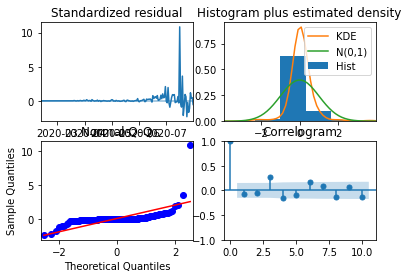

In [39]:
review_Model ('Bexar')

NameError: name 'data' is not defined

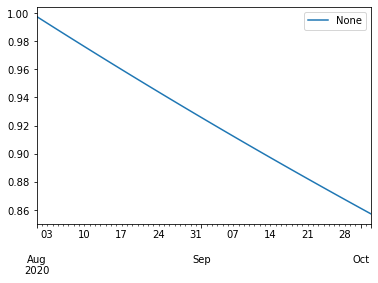

In [40]:
# function to compare train and test for a given model
def compare_train_test(train, result):
    start = len(train) 
    end = len(train) + len(test) - 1

    # Predictions for one-year against the test set 
    predictions = result.predict(start, end).rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
data.plot(legend = True)

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(15,10))
npre = 4
ax.set(title= f'{CtyName} Covid-19 Cases', xlabel='Date', ylabel='Number of Cases')

# Plot data points
data.loc['2020-04-01':].plot(ax=ax, style='o', label='Observed Cases')

# Plot predictions
SARIMAX_forecast.loc['2020-10-03':].plot(ax=ax, style='r--', label='Sarimax forecast')

legend = ax.legend(loc='lower right')
ax.set_xlim(np.datetime64('2020-04-01'), np.datetime64('2020-12-31'))